In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

class BinomialAsset:
    '''
    A class representing a binomial asset with a given probability of up return and down return.

    Args:
        p (float): Probability of the risky asset yielding the up return.
        up_return (float): Excess return of the risky asset’s up state over 1 (up_return - 1).
        down_return (float): Excess return of the risky asset’s down state over 1 (down_return - 1).

    Returns:
        float: The sample return of the risky asset.
    '''
    def __init__(self, p=0.6, up_return=1.1, down_return=0.9):
        self.p = p
        self.up_return = up_return
        self.down_return = down_return
        
    def sample(self):
        return self.up_return if np.random.random() < self.p else self.down_return

@jit(nopython=True)
def calculate_theoretical_allocation_pct(wealth, step, max_steps, p, a, b, r, risk_aversion):
    """Calculates the Bellman equation theoretical optimal allocation percentage to the risky asset.

    Args:
        wealth (float): Current wealth of the portfolio.
        step (int): Current time step in the simulation.
        max_steps (int): Total number of time steps in the environment.
        p (float): Probability of the risky asset yielding the up return.
        a (float): Excess return of the risky asset’s up state over 1 (up_return - 1).
        b (float): Excess return of the risky asset’s down state over 1 (down_return - 1).
        r (float): Risk-free rate of return over 1 (risk_free_return - 1).
        risk_aversion (float): Risk aversion parameter for the utility function.

    Returns:
        float: Optimal allocation percentage to the risky asset, clipped between 0 and 1.
    """
    steps_remaining = max_steps - step
    if steps_remaining <= 0:
        return 0.0
    numerator = np.log(p * (a - r) / ((1 - p) * (r - b)))
    denominator = risk_aversion * (1 + r) ** steps_remaining * (a - b)
    result = numerator / denominator / wealth
    return min(max(result, 0.0), 1.0)

class PortfolioEnvironment:
    '''
    A class representing a portfolio environment with a given maximum number of steps, initial wealth, risk-free rate, risky asset, risk aversion, and intermediate reward.

    Args:
        max_steps (int): The maximum number of steps in the environment.
        initial_wealth (float): The initial wealth of the portfolio.
        risk_free_rate (float): The risk-free rate of return over 1 (risk_free_return - 1).
        risky_asset (BinomialAsset): The risky asset in the portfolio.
        risk_aversion (float): The risk aversion parameter for the utility function.
        intermediate_reward (bool): Whether to use intermediate reward.
    '''
    def __init__(self, max_steps, initial_wealth, risk_free_rate, risky_asset, risk_aversion, intermediate_reward=False):
        self.max_steps = max_steps
        self.initial_wealth = initial_wealth
        self.risk_free_rate = risk_free_rate
        self.risk_free_return = 1 + risk_free_rate
        self.risky_asset = risky_asset
        self.risk_aversion = risk_aversion
        self.p = risky_asset.p
        self.a = risky_asset.up_return - 1
        self.b = risky_asset.down_return - 1
        self.r = self.risk_free_return - 1
        self.intermediate_reward = intermediate_reward
        self.agent_actions = None  # Will be set later with agent's action space
        self.reset()
    
    def reset(self):
        '''
        Resets the environment to the initial state.

        Returns:
            np.array: The initial state of the environment.
        '''
        self.wealth = self.initial_wealth
        self.step_count = 0
        steps_remaining = self.max_steps - self.step_count
        return np.array([self.wealth, steps_remaining])  # Use steps_remaining instead of step_count
    
    def get_theoretical_allocation_pct(self, state):
        '''
        Caller function for the Bellman equation theoretical optimal allocation percentage to the risky asset.

        Args:
            state (np.array): The current state of the environment.

        Returns:
            float: The theoretical optimal allocation percentage to the risky asset.
        '''
        wealth, step = state
        return calculate_theoretical_allocation_pct(
            wealth, step, self.max_steps, self.p, self.a, self.b, self.r, self.risk_aversion
        )
    
    def get_theoretical_allocation_pct_mapped(self, state):
        """
        Get the theoretical allocation percentage and map it to the nearest
        available action in the action space.
        
        Parameters:
        -----------
        state : array-like
            The state for which to calculate the theoretical allocation
        
        Returns:
        --------
        float
            The theoretical allocation mapped to the nearest available action
        """
        # Get the continuous theoretical allocation
        theoretical_alloc = self.get_theoretical_allocation_pct(state)
        
        # Find the index of the closest action in the action space
        if self.agent_actions is not None:
            action_idx = np.argmin(np.abs(self.agent_actions - theoretical_alloc))
            # Return the mapped action
            return self.agent_actions[action_idx]
        else:
            # If agent_actions isn't set, return the continuous value
            return theoretical_alloc
    
    def step(self, action):
        '''
        Takes an action and updates the environment.

        Args:
            action (float): The action to take.

        Returns:
            tuple: A tuple containing the next state, reward, done, and info.
        '''
        action = np.clip(action, 0, 1)
        risky_return = self.risky_asset.sample()
        portfolio_return = action * risky_return + (1 - action) * self.risk_free_return
        prev_wealth = self.wealth
        self.wealth *= portfolio_return
        self.step_count += 1
        done = self.step_count >= self.max_steps
        
        # Reward shaping: wealth growth + terminal utility
        if self.intermediate_reward:
            growth_reward = (self.wealth - prev_wealth) * 10  # Amplify wealth change
            terminal_reward = (1 - np.exp(-self.risk_aversion * self.wealth)) / self.risk_aversion * 100 if done else 0
            reward = growth_reward + terminal_reward
        else:
            terminal_reward = (1 - np.exp(-self.risk_aversion * self.wealth)) / self.risk_aversion * 100 if done else 0
            reward = terminal_reward
        
        next_state = np.array([self.wealth, self.max_steps - self.step_count])  # Return steps_remaining
        
        # Get continuous theoretical allocation
        theoretical_alloc = self.get_theoretical_allocation_pct(next_state)
        
        # Get mapped theoretical allocation
        theoretical_alloc_mapped = self.get_theoretical_allocation_pct_mapped(next_state)
        
        info = {
            'action': action,
            'theoretical_alloc': theoretical_alloc,
            'theoretical_alloc_mapped': theoretical_alloc_mapped,
            'difference': abs(action - theoretical_alloc),
            'difference_mapped': abs(action - theoretical_alloc_mapped),
            'wealth': self.wealth
        }
        
        return next_state, reward, done, info

class SARSAAgentWithVisitCounts:
    '''
    A class representing a SARSA agent with visit counts.

    Args:
        env (PortfolioEnvironment): The environment to train the agent on.
        n_wealth_bins (int): The number of wealth bins.
        learning_rate (float): The learning rate.
        gamma (float): The discount factor.
    '''
    def __init__(self, env, n_wealth_bins=25, learning_rate=0.1, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, n_actions=21, episodes=100000,
                 policy_probs=[0.33, 0.33, 0.34]):  # Probabilities for each policy type
        self.env = env
        self.alpha = learning_rate
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.num_episodes = episodes
        self.n_wealth_bins = n_wealth_bins
        self.n_time_steps = env.max_steps + 1
        self.wealth_bins = np.linspace(0, 5.0, n_wealth_bins + 1)
        self.n_actions = n_actions
        self.actions = np.linspace(0, 1, n_actions)
        self.q_table = np.ones((n_wealth_bins, self.n_time_steps, n_actions), dtype=np.float32) * 0.1
        
        # Set agent's action space in the environment
        env.agent_actions = self.actions
        
        # Initialize visit counts
        self.visit_counts = np.zeros((n_wealth_bins, self.n_time_steps, n_actions), dtype=np.int32)
        
        # Policy probabilities
        self.policy_probs = policy_probs  # [uniform, best_policy, least_frequent]
    
    def discretize_state(self, state):
        '''
        Discretizes the state into nearest wealth bin and time step.

        Args:
            state (np.array): The current state of the environment.

        Returns:
            np.array: The discretized state.
        '''
        wealth, steps_remaining = state
        wealth_idx = np.clip(np.searchsorted(self.wealth_bins, wealth) - 1, 0, self.n_wealth_bins - 1)
        time_idx = min(max(steps_remaining, 0), self.n_time_steps - 1)
        return np.array([int(wealth_idx), int(time_idx)])
    
    def get_action(self, state, explore=True):
        '''
        Gets the action to take based on the current state and exploration flag.

        Args:
            state (np.array): The current state of the environment.
            explore (bool): Whether to explore.

        Returns:
            float: The action to take.  
        '''
        state_idx = self.discretize_state(state)
        if explore and np.random.random() < self.epsilon:
            # Choose a policy based on policy_probs
            policy_type = np.random.choice(3, p=self.policy_probs)
            
            if policy_type == 0:
                # 1. Random uniform exploration
                action_idx = np.random.randint(self.n_actions)
                
            elif policy_type == 1:
                # 2. Best existing policy (exploitation)
                action_idx = np.argmax(self.q_table[state_idx[0], state_idx[1]])
                
            else:
                # 3. Least frequent walked path
                # Get the least visited actions for this state
                state_visits = self.visit_counts[state_idx[0], state_idx[1]]
                min_visits = np.min(state_visits)
                
                # Find all actions with minimum visits
                min_visit_indices = np.where(state_visits == min_visits)[0]
                
                # If there are multiple with the same minimum, choose based on Q-values
                if len(min_visit_indices) > 1:
                    # Select the one with the highest Q-value among the least visited
                    q_values_for_min_visits = self.q_table[state_idx[0], state_idx[1], min_visit_indices]
                    best_min_visit_idx = np.argmax(q_values_for_min_visits)
                    action_idx = min_visit_indices[best_min_visit_idx]
                else:
                    action_idx = min_visit_indices[0]
        else:
            # Always use the best policy when not exploring
            action_idx = np.argmax(self.q_table[state_idx[0], state_idx[1]])
        
        return self.actions[action_idx]
    
    def update(self, state, action, reward, next_state, next_action, done, episode):
        '''
        Updates the Q-table and visit counts.

        Args:
            state (np.array): The current state of the environment.
            action (float): The action to take.
            reward (float): The reward for the action.
            next_state (np.array): The next state of the environment.
        
        Returns:
            float: The absolute TD error.
        '''
        state_idx = self.discretize_state(state)
        action_idx = int(np.argmin(np.abs(self.actions - action)))
        
        # Update visit counts
        self.visit_counts[state_idx[0], state_idx[1], action_idx] += 1
        
        # Check how well-explored this state is
        state_visits = np.sum(self.visit_counts[state_idx[0], state_idx[1], :])
        
        # Use higher learning rate for less-explored states
        if state_visits < 100:
            learning_boost = 3.0  # Much higher learning rate for rare states
        elif state_visits < 1000:
            learning_boost = 2.0  # Higher learning rate for uncommon states
        else:
            learning_boost = 1.0  # Normal learning rate for common states
        
        alpha = (self.alpha / (1 + episode / 20000)) * learning_boost
        
        # Standard TD update 
        q_current = self.q_table[state_idx[0], state_idx[1], action_idx]
        q_next = 0
        if not done:
            next_state_idx = self.discretize_state(next_state)
            next_action_idx = int(np.argmin(np.abs(self.actions - next_action)))
            q_next = self.q_table[next_state_idx[0], next_state_idx[1], next_action_idx]
        
        td_error = reward + self.gamma * q_next - q_current
        self.q_table[state_idx[0], state_idx[1], action_idx] += alpha * td_error
        
        return abs(td_error)
    
    def decay_epsilon(self, episode):
        '''
        Decays the epsilon value and updates the policy probabilities.

        Args:
            episode (int): The current episode number.
        '''
        # Slow epsilon decay
        progress = min(1.0, episode / (self.num_episodes))
        self.epsilon = max(self.epsilon_end, self.epsilon_start - progress * (self.epsilon_start - self.epsilon_end))
        
        # Adjust policy probabilities as training progresses
        # Start with more exploration, gradually shift to more exploitation
        exploration_weight = self.epsilon  # As epsilon decreases
        
        # Adjust policy probabilities: more uniform and least-frequent early on,
        # more best-policy later
        self.policy_probs = [
            0.4 * exploration_weight,                   # uniform random (decreases with time)
            0.2 + 0.6 * (1 - exploration_weight),       # best policy (increases with time)
            0.4 * exploration_weight + 0.2 * (1 - exploration_weight)  # least frequent (decreases but not to zero)
        ]
        
        # Normalize to ensure they sum to 1
        self.policy_probs = np.array(self.policy_probs) / sum(self.policy_probs)
    
    def get_best_action(self, state):
        '''
        Gets the best action for a given state.

        Args:
            state (np.array): The current state of the environment.

        Returns:
            float: The best action for the given state.
        '''
        state_idx = self.discretize_state(state)
        action_idx = np.argmax(self.q_table[state_idx[0], state_idx[1]])
        return self.actions[action_idx]
    
    def get_visit_statistics(self):
        '''
        Gets the visit statistics.

        Returns:
            dict: A dictionary containing the visit statistics.
        '''
        # Calculate visit statistics
        total_visits = np.sum(self.visit_counts)
        max_visits = np.max(self.visit_counts)
        min_visits = np.min(self.visit_counts[self.visit_counts > 0]) if np.any(self.visit_counts > 0) else 0
        unvisited = np.sum(self.visit_counts == 0)
        
        return {
            "total_visits": total_visits,
            "max_visits": max_visits,
            "min_visits": min_visits,
            "unvisited": unvisited,
            "visit_std": np.std(self.visit_counts[self.visit_counts > 0]) if np.any(self.visit_counts > 0) else 0
        }

def train_tabular_sarsa(env, agent, num_episodes=100000, eval_interval=1000, verbose=True):
    '''
    Trains the SARSA agent on the environment.

    Args:
        env (PortfolioEnvironment): The environment to train the agent on.
        agent (SARSA): The agent to train.
        num_episodes (int): The number of episodes to train the agent on.
    
    Returns:
        tuple: A tuple containing the rewards history, theoretical differences, theoretical differences mapped, actions history, and TD errors history.
        agent (SARSA): The trained agent.
    '''
    rewards_history = []
    theoretical_diffs = []
    theoretical_diffs_mapped = []  # Track mapped differences
    actions_history = []
    td_errors_history = []
    visit_stats_history = []
    
    for episode in range(num_episodes):
        state = env.reset()
        action = agent.get_action(state, explore=True)
        total_reward = 0
        step_differences = []
        step_differences_mapped = []  # Track mapped differences
        step_actions = []
        td_errors = []
        
        done = False
        while not done:
            next_state, reward, done, info = env.step(action)
            step_differences.append(info['difference'])
            step_differences_mapped.append(info['difference_mapped'])  # Store mapped difference
            step_actions.append(action)
            next_action = agent.get_action(next_state, explore=True)
            td_error = agent.update(state, action, reward, next_state, next_action, done, episode)
            td_errors.append(td_error)
            total_reward += reward
            state = next_state
            action = next_action
        
        rewards_history.append(total_reward)
        
        if episode % eval_interval == 0:
            theoretical_diffs.append(np.mean(step_differences))
            theoretical_diffs_mapped.append(np.mean(step_differences_mapped))  # Store mapped diff
            actions_history.append(np.mean(step_actions))
            td_errors_history.append(np.mean(td_errors))
            
            # Get visit statistics
            if hasattr(agent, 'get_visit_statistics'):
                visit_stats = agent.get_visit_statistics()
                visit_stats_history.append(visit_stats)
                
                if verbose and (episode % (10 * eval_interval) == 0 or episode == 0):
                    print(f"Episode {episode}: Reward = {np.mean(rewards_history[-eval_interval:]):.2f}, "
                          f"Theo Diff = {np.mean(step_differences):.4f}, "
                          f"Theo Diff Mapped = {np.mean(step_differences_mapped):.4f}, "
                          f"TD Error = {np.mean(td_errors):.6f}, "
                          f"Unvisited = {visit_stats['unvisited']}, "
                          f"Policy probs = {np.round(agent.policy_probs, 2)}")
            else:
                if verbose and (episode % (10 * eval_interval) == 0 or episode == 0):
                    print(f"Episode {episode}: Reward = {np.mean(rewards_history[-eval_interval:]):.2f}, "
                          f"Theo Diff = {np.mean(step_differences):.4f}, "
                          f"Theo Diff Mapped = {np.mean(step_differences_mapped):.4f}, "
                          f"TD Error = {np.mean(td_errors):.6f}")
            
            # Check convergence criteria (optional)
            if len(td_errors_history) >= 10 and np.mean(td_errors_history[-100:]) <= 0.5:
                print(f"Converged at episode {episode} with TD error {np.mean(td_errors_history[-10:]):.6f}")
                break
            
        agent.decay_epsilon(episode)
    
    result_dict = {
        'rewards': np.array(rewards_history),
        'theoretical_diffs': np.array(theoretical_diffs),
        'theoretical_diffs_mapped': np.array(theoretical_diffs_mapped),  # Include mapped diffs
        'actions': np.array(actions_history),
        'td_errors': np.array(td_errors_history)
    }
    
    if hasattr(agent, 'get_visit_statistics'):
        result_dict['visit_stats'] = visit_stats_history
    
    return result_dict, agent

def moving_average(data, window_size=500):
    """
    Calculate a conventional moving average with the given window size.

    Args:
        data (np.array): The data to calculate the moving average of.
        window_size (int): The window size of the moving average.

    Returns:
        np.array: The moving average of the data.
    """
    result = np.zeros_like(data, dtype=float)
    
    # Fill initial points where we don't have a full window
    for i in range(min(window_size, len(data))):
        # For each early point, average what we have so far
        result[i] = np.mean(data[:i+1])
    
    # Calculate standard sliding window average for remaining points
    for i in range(window_size, len(data)):
        result[i] = np.mean(data[i-window_size+1:i+1])
        
    return result

def visualize_training(results, ma_window=500, show_raw=False, suffix='', env=None, save_fig=False):
    """
    Visualize training metrics with a conventional moving average.

    Args:
        results (dict): A dictionary containing the rewards history, theoretical differences, theoretical differences mapped, actions history, and TD errors history.
        ma_window (int): The window size of the moving average.
        show_raw (bool): Whether to show the raw data.
        suffix (str): The suffix of the figure.
        env (PortfolioEnvironment): The environment to visualize the training metrics on.
        save_fig (bool): Whether to save the figure.
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    # Debug raw data
    print("Raw data lengths:")
    for key in ['rewards', 'theoretical_diffs', 'theoretical_diffs_mapped', 'actions', 'td_errors']:
        if key in results:
            print(f"  {key}: {len(results[key])}")
    
    # Indices
    reward_indices = np.arange(len(results['rewards']))
    eval_indices = np.linspace(0, len(results['rewards']) - 1, len(results['theoretical_diffs']), dtype=int)
    print(f"Indices: Rewards={len(reward_indices)}, Eval={len(eval_indices)}")
    
    # Moving averages
    ma_rewards = moving_average(results['rewards'], ma_window)
    ma_diffs = moving_average(results['theoretical_diffs'], ma_window)
    ma_diffs_mapped = moving_average(results['theoretical_diffs_mapped'], ma_window)
    ma_actions = moving_average(results['actions'], ma_window)
    ma_td_errors = moving_average(results['td_errors'], ma_window)
    
    # Debug MA
    print("MA lengths:")
    print(f"  MA rewards: {len(ma_rewards)}")
    print(f"  MA diffs: {len(ma_diffs)}")
    print(f"  MA diffs mapped: {len(ma_diffs_mapped)}")
    print(f"  MA actions: {len(ma_actions)}")
    print(f"  MA td errors: {len(ma_td_errors)}")
    
    # Plot 1: Theoretical difference (both regular and mapped)
    if len(results['theoretical_diffs']) > 0:
        axes[0].plot(eval_indices, ma_diffs, 'b-', linewidth=2, label=f'Theoretical Diff (window={ma_window})')
        axes[0].plot(eval_indices, ma_diffs_mapped, 'c--', linewidth=2, label=f'Mapped Diff (window={ma_window})')
        axes[0].set_title('Difference from Theoretical Optimal')
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Average Difference')
        axes[0].legend()
        print(f"Theo diffs plot: x={len(eval_indices)}, y_ma={len(ma_diffs)}, y_ma_mapped={len(ma_diffs_mapped)}")
    
    # Plot 2: Rewards
    if len(results['rewards']) > 0:
        axes[1].plot(reward_indices, ma_rewards, 'g-', linewidth=2, label=f'Moving Avg (window={ma_window})')
        axes[1].set_title('Total Rewards')
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Reward')
        axes[1].legend()
        print(f"Rewards plot: x={len(reward_indices)}, y_ma={len(ma_rewards)}")
    
    # Plot 3: Actions
    if len(results['actions']) > 0:
        axes[2].plot(eval_indices, ma_actions, 'r-', linewidth=2, label=f'Moving Avg (window={ma_window})')
        axes[2].set_title('Action Allocation')
        axes[2].set_xlabel('Episode')
        axes[2].set_ylabel('Average Allocation')
        if env:
            # Calculate continuous theoretical optimal
            wealth_vals = np.array([env.initial_wealth])
            time_vals = np.arange(env.max_steps + 1)
            theoretical_values = []
            for t in time_vals:
                theoretical_values.append(env.get_theoretical_allocation_pct([env.initial_wealth, t]))
            theoretical_mean = np.mean(theoretical_values)
            
            # Calculate mapped theoretical optimal
            theoretical_values_mapped = []
            for t in time_vals:
                theoretical_values_mapped.append(env.get_theoretical_allocation_pct_mapped([env.initial_wealth, t]))
            theoretical_mean_mapped = np.mean(theoretical_values_mapped)
            
            # Plot both theoretical lines
            axes[2].axhline(y=theoretical_mean, color='k', linestyle='--', label=f'Theoretical: {theoretical_mean:.4f}')
            axes[2].axhline(y=theoretical_mean_mapped, color='k', linestyle=':', label=f'Theo Mapped: {theoretical_mean_mapped:.4f}')
        
        axes[2].legend()
        print(f"Actions plot: x={len(eval_indices)}, y_ma={len(ma_actions)}")
    
    # Plot 4: TD Errors
    if len(results['td_errors']) > 0:
        axes[3].plot(eval_indices, ma_td_errors, 'm-', linewidth=2, label=f'Moving Avg (window={ma_window})')
        axes[3].set_title('TD Error')
        axes[3].set_xlabel('Episode')
        axes[3].set_ylabel('Average TD Error')
        axes[3].legend()
        print(f"TD errors plot: x={len(eval_indices)}, y_ma={len(ma_td_errors)}")
    
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'training_metrics_ma_{suffix}.png')
    plt.show()

    

# Xt mid case

Episode 0: Reward = 155.12, Theo Diff = 0.5144, Theo Diff Mapped = 0.5150, TD Error = 15.503397, Unvisited = 5765, Policy probs = [0.33 0.33 0.34]
Episode 10000: Reward = 142.59, Theo Diff = 0.4423, Theo Diff Mapped = 0.4550, TD Error = 13.239376, Unvisited = 2995, Policy probs = [0.4  0.21 0.4 ]
Episode 20000: Reward = 143.32, Theo Diff = 0.4356, Theo Diff Mapped = 0.4400, TD Error = 11.919294, Unvisited = 2916, Policy probs = [0.39 0.21 0.4 ]
Episode 30000: Reward = 144.65, Theo Diff = 0.4899, Theo Diff Mapped = 0.4950, TD Error = 12.712805, Unvisited = 2890, Policy probs = [0.39 0.22 0.39]
Episode 40000: Reward = 142.78, Theo Diff = 0.1979, Theo Diff Mapped = 0.1900, TD Error = 9.234402, Unvisited = 2875, Policy probs = [0.38 0.22 0.39]
Episode 50000: Reward = 142.54, Theo Diff = 0.3495, Theo Diff Mapped = 0.3450, TD Error = 11.245365, Unvisited = 2870, Policy probs = [0.38 0.23 0.39]
Episode 60000: Reward = 142.62, Theo Diff = 0.4050, Theo Diff Mapped = 0.4050, TD Error = 10.824467

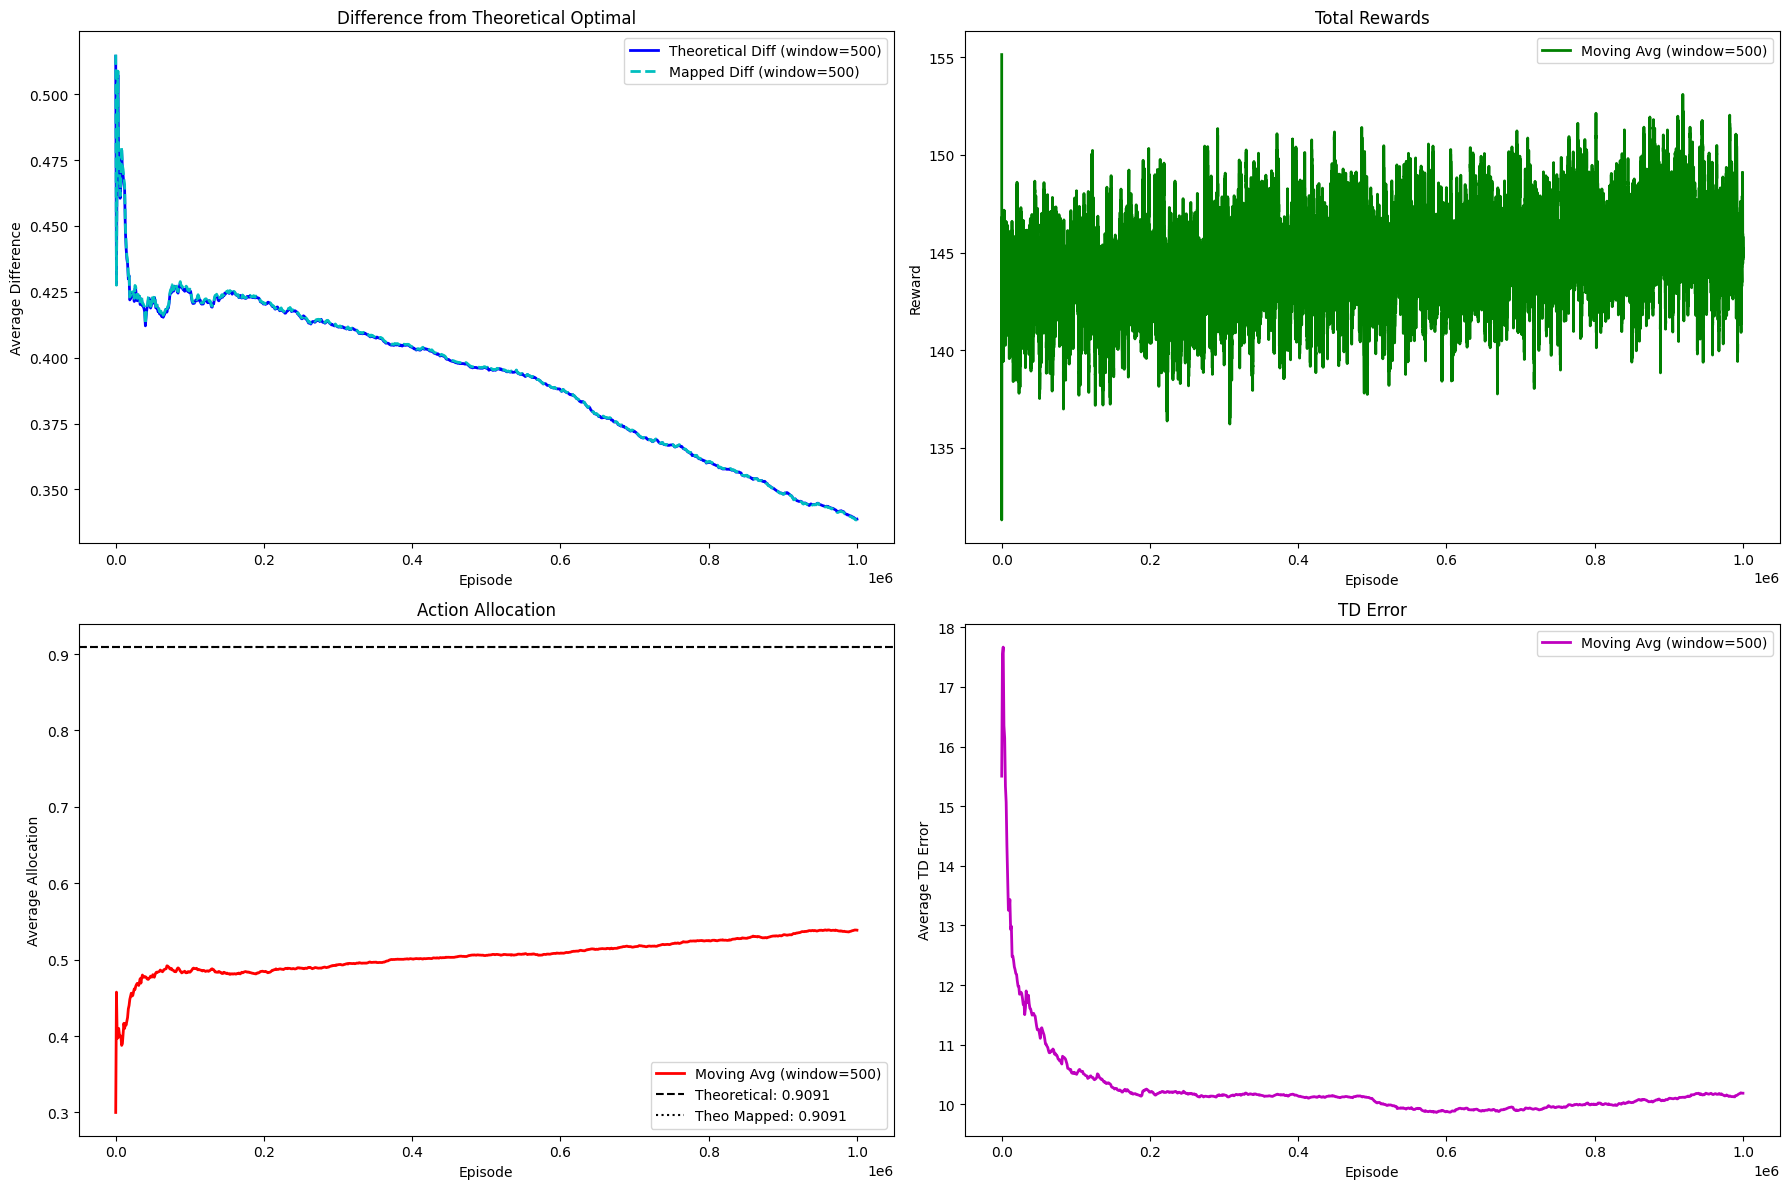

In [11]:
risky_asset_xtmid = BinomialAsset(
    p=0.7,                # Moderate probability of up movement  
    up_return=1.3,       # Moderate up return
    down_return=0.7       # Moderate downside
)
env_xtmid = PortfolioEnvironment(
    max_steps=10,
    initial_wealth=1.0,
    risk_free_rate=0.06,  # Slightly higher risk-free rate
    risky_asset=risky_asset_xtmid,
    risk_aversion=0.4      # Moderate-to-low risk aversion
)

# Use the agent with visit counts
agent_xtmid = SARSAAgentWithVisitCounts(
    env_xtmid,
    n_wealth_bins=25,
    learning_rate=0.2,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    n_actions=21,
    episodes=3000000
)


np.random.seed(42)
results_xtmid,xtmid_agent = train_tabular_sarsa(env_xtmid, agent_xtmid, num_episodes=agent_xtmid.num_episodes)
visualize_training(results_xtmid, env=env_xtmid,save_fig=True,suffix='final_xtmid')


# Xt = 1 Case

Episode 0: Reward = 140.52, Theo Diff = 0.4100, Theo Diff Mapped = 0.4100, TD Error = 14.043145, Unvisited = 5765, Policy probs = [0.66 0.   0.34]
Episode 10000: Reward = 126.99, Theo Diff = 0.4750, Theo Diff Mapped = 0.4750, TD Error = 3.277661, Unvisited = 5085, Policy probs = [0.4 0.2 0.4]
Episode 20000: Reward = 126.39, Theo Diff = 0.4600, Theo Diff Mapped = 0.4600, TD Error = 2.733212, Unvisited = 5054, Policy probs = [0.4 0.2 0.4]
Episode 30000: Reward = 126.84, Theo Diff = 0.5000, Theo Diff Mapped = 0.5000, TD Error = 2.417439, Unvisited = 5036, Policy probs = [0.4  0.21 0.4 ]
Episode 40000: Reward = 126.56, Theo Diff = 0.5300, Theo Diff Mapped = 0.5300, TD Error = 1.944890, Unvisited = 5025, Policy probs = [0.39 0.21 0.4 ]
Episode 50000: Reward = 126.97, Theo Diff = 0.5400, Theo Diff Mapped = 0.5400, TD Error = 2.314177, Unvisited = 5014, Policy probs = [0.39 0.21 0.4 ]
Episode 60000: Reward = 128.34, Theo Diff = 0.4300, Theo Diff Mapped = 0.4300, TD Error = 3.133597, Unvisited

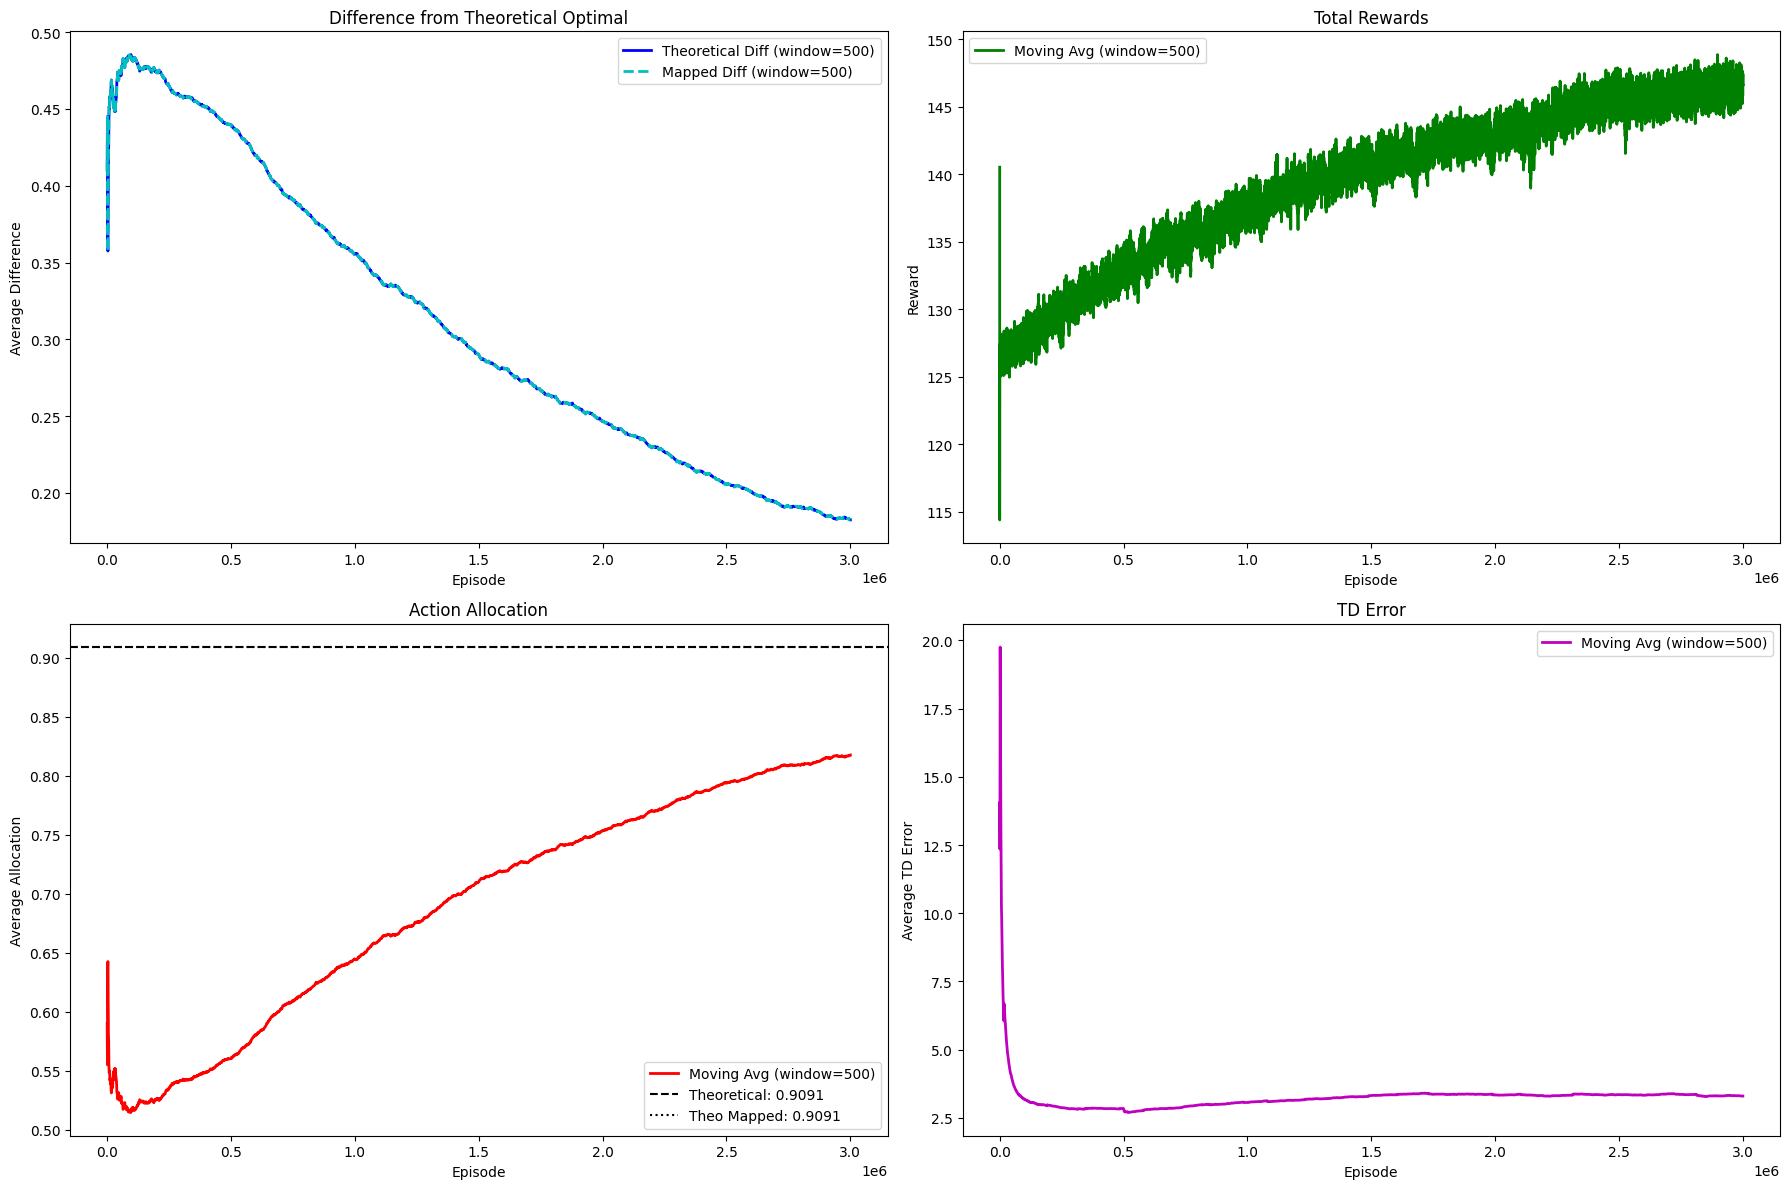

In [5]:
risky_asset_xt1 = BinomialAsset(
    p=0.7,               # Moderate probability of up movement  
    up_return=1.1,       # Moderate up return
    down_return=0.99        # Moderate downside
)
env_xt1 = PortfolioEnvironment(
    max_steps=10,
    initial_wealth=1.0,
    risk_free_rate=0.01,   # Standard risk-free rate
    risky_asset=risky_asset_xt1,
    risk_aversion=0.2
)

# Use the agent with visit counts
agent_xt1 = SARSAAgentWithVisitCounts(
    env_xt1,
    n_wealth_bins=25,
    learning_rate=0.2,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    n_actions=21,
    episodes=3000000
)


np.random.seed(42)
results_xt1, xt1_agent = train_tabular_sarsa(env_xt1, agent_xt1, num_episodes=agent_xt1.num_episodes)
visualize_training(results_xt1, env=env_xt1,save_fig=True,suffix='final_xt1')


# Xt = 0 Case

Episode 0: Reward = 70.63, Theo Diff = 0.3000, Theo Diff Mapped = 0.3000, TD Error = 7.054129, Unvisited = 5765, Policy probs = [0.33 0.33 0.34]
Episode 10000: Reward = 56.74, Theo Diff = 0.4950, Theo Diff Mapped = 0.4950, TD Error = 0.955325, Unvisited = 5216, Policy probs = [0.4 0.2 0.4]
Episode 20000: Reward = 57.58, Theo Diff = 0.4150, Theo Diff Mapped = 0.4150, TD Error = 0.941074, Unvisited = 5201, Policy probs = [0.4 0.2 0.4]
Episode 30000: Reward = 57.67, Theo Diff = 0.5350, Theo Diff Mapped = 0.5350, TD Error = 0.889107, Unvisited = 5191, Policy probs = [0.4  0.21 0.4 ]
Episode 40000: Reward = 58.13, Theo Diff = 0.5300, Theo Diff Mapped = 0.5300, TD Error = 0.975533, Unvisited = 5181, Policy probs = [0.39 0.21 0.4 ]
Episode 50000: Reward = 58.22, Theo Diff = 0.6850, Theo Diff Mapped = 0.6850, TD Error = 1.304592, Unvisited = 5176, Policy probs = [0.39 0.21 0.4 ]
Episode 60000: Reward = 58.34, Theo Diff = 0.4100, Theo Diff Mapped = 0.4100, TD Error = 1.264655, Unvisited = 5169,

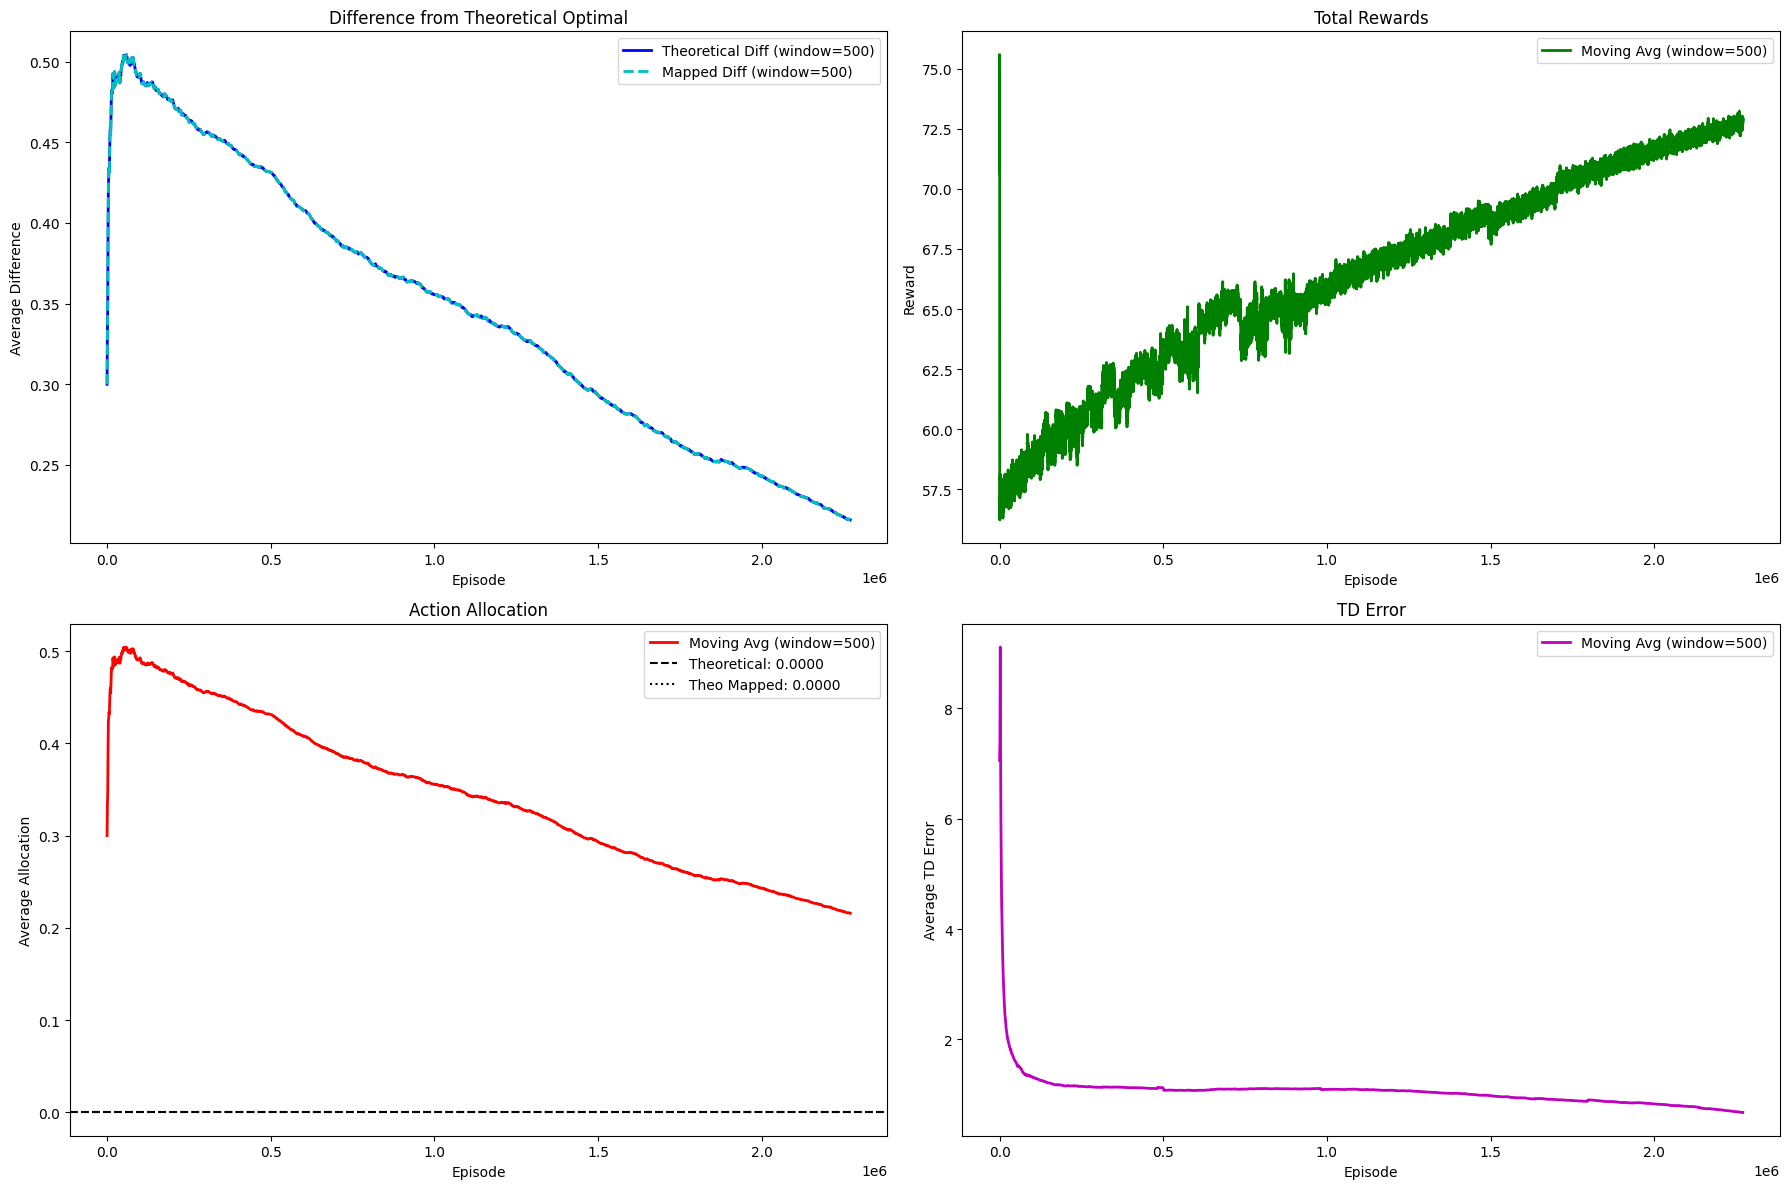

In [7]:
risky_asset_xt0 = BinomialAsset(
    p=0.1,               # Moderate probability of up movement  
    up_return=1.011,       # Moderate up return
    down_return=0.9        # Moderate downside
)
env_xt0 = PortfolioEnvironment(
    max_steps=10,
    initial_wealth=1.0,
    risk_free_rate=0.01,   # Standard risk-free rate
    risky_asset=risky_asset_xt0,
    risk_aversion=0.5      # Moderate risk aversion
)

# Use the agent with visit counts
agent_xt0 = SARSAAgentWithVisitCounts(
    env_xt0,
    n_wealth_bins=25,
    learning_rate=0.2,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    n_actions=21,
    episodes=3000000
)


np.random.seed(42)
results_xt0, xt0_agent = train_tabular_sarsa(env_xt0, agent_xt0, num_episodes=agent_xt0.num_episodes)
visualize_training(results_xt0, env=env_xt0,save_fig=False,suffix='final_xt0')

# Unit test

In [17]:
import ipytest
import pytest
import numpy as np
from unittest.mock import patch

# Configure ipytest
ipytest.autoconfig()

# Fixtures to create reusable objects
@pytest.fixture
def binomial_asset():
    '''
    Creates a binomial asset.

    Returns:
        BinomialAsset: A binomial asset.
    '''
    return BinomialAsset(p=0.5, up_return=1.1, down_return=0.9)

@pytest.fixture
def env(binomial_asset):
    '''
    Creates a portfolio environment.

    Args:
        binomial_asset (BinomialAsset): The binomial asset to use in the environment.

    Returns:
        PortfolioEnvironment: A portfolio environment.
    '''
    return PortfolioEnvironment(
        max_steps=10,
        initial_wealth=1.0,
        risk_free_rate=0.02,
        risky_asset=binomial_asset,
        risk_aversion=1.0,
        intermediate_reward=False
    )

@pytest.fixture
def agent(env):
    '''
    Creates a SARSA agent with visit counts.

    Args:
        env (PortfolioEnvironment): The environment to train the agent on.

    Returns:
        SARSAAgentWithVisitCounts: A SARSA agent with visit counts.
    '''
    return SARSAAgentWithVisitCounts(
        env=env,
        n_wealth_bins=25,
        learning_rate=0.1,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        n_actions=21,
        episodes=100000,
        policy_probs=[0.4, 0.2, 0.4]  # [random, best_action, least_frequent]
    )

# Test Environment Reset
def test_environment_reset(env):
    '''
    Tests the environment reset.

    Args:
        env (PortfolioEnvironment): The environment to test.

    Returns:
        None.
    '''
    state = env.reset()
    assert state[0] == 1.0, "Initial wealth should be 1.0"
    assert state[1] == 10, "Initial steps remaining should be 10"
    assert env.step_count == 0, "Step count should be 0 after reset"
    assert env.wealth == 1.0, "Wealth should be 1.0 after reset"

# Test Environment Step
def test_environment_step(env):
    '''
    Tests the environment step.

    Args:
        env (PortfolioEnvironment): The environment to test.

    Returns:
        None.
    '''
    env.reset()
    action = 0.5  # Allocate 50% to risky asset
    with patch.object(env.risky_asset, 'sample', return_value=1.1):
        next_state, reward, done, _ = env.step(action)
    expected_wealth = 1.0 * (0.5 * 1.1 + 0.5 * 1.02)  # 50% risky, 50% risk-free
    assert next_state[0] == pytest.approx(expected_wealth), "Wealth not updated correctly"
    assert next_state[1] == 9, "Steps remaining should decrease by 1"
    assert not done, "Should not be done after first step"
    assert reward == 0, "Reward should be 0 when intermediate_reward=False"

    # Test terminal step
    env.step_count = 9
    with patch.object(env.risky_asset, 'sample', return_value=1.1):
        next_state, reward, done, _ = env.step(action)
    expected_wealth *= (0.5 * 1.1 + 0.5 * 1.02)
    expected_reward = (1 - np.exp(-1.0 * expected_wealth)) / 1.0 * 100
    assert next_state[0] == pytest.approx(expected_wealth), "Terminal wealth incorrect"
    assert next_state[1] == 0, "Steps remaining should be 0"
    assert done, "Should be done at max_steps"
    assert reward == pytest.approx(expected_reward), "Terminal reward incorrect"

# Test Theoretical Allocation
def test_calculate_theoretical_allocation_pct():
    '''
    Tests the theoretical allocation.

    Args:
        wealth (float): The current wealth.
        step (int): The current step.
        max_steps (int): The maximum steps.
    '''
    
    wealth = 1.0
    step = 9  # steps_remaining = 1
    max_steps = 10
    p = 0.7
    a = 0.1
    b = -0.05
    r = 0.02
    risk_aversion = 1.0
    alloc = calculate_theoretical_allocation_pct(wealth, step, max_steps, p, a, b, r, risk_aversion)
    # Expected: log(0.7*(0.1-0.02)/(0.3*(0.02-(-0.05)))) / (1.0 * 1.02 * 0.15) ≈ 1.0 (clipped)
    assert alloc == 1.0, "Theoretical allocation should be 1.0"

# Test State Discretization
def test_discretize_state(agent):
    '''
    Tests the state discretization.

    Args:
        agent (SARSA): The agent to test.
    '''
    state = np.array([0.3, 3])
    discrete_state = agent.discretize_state(state)
    # wealth_bins = np.linspace(0, 5.0, 25+1), so step=0.2, 0.3 is in bin 1 (0.2 to 0.4)
    assert discrete_state[0] == 1, "Wealth=0.3 should be in bin 1"
    assert discrete_state[1] == 3, "Steps remaining=3 should map to time_idx=3"

    state = np.array([5.0, 0])
    discrete_state = agent.discretize_state(state)
    assert discrete_state[0] == 24, "Wealth=5.0 should be in last bin (24)"
    assert discrete_state[1] == 0, "Steps remaining=0 should map to time_idx=0"

# Test Action Selection
def test_get_action(agent):
    '''
    Tests the action selection.

    Args:
        agent (SARSA): The agent to test.
    '''
    state = np.array([1.0, 5])
    agent.epsilon = 0.0  # Greedy
    # wealth=1.0 -> bin 4 (0.8 to 1.0), time_idx=5
    agent.q_table[4, 5, :] = 0.1
    agent.q_table[4, 5, 10] = 1.0  # Action 10 -> 0.5
    action = agent.get_action(state, explore=False)
    assert action == pytest.approx(0.5), "Should select action with highest Q-value (0.5)"

    # Test exploration (policy_type=0: uniform random)
    agent.epsilon = 1.0
    with patch('numpy.random.random', return_value=0.0):
        with patch('numpy.random.choice', return_value=0):
            with patch('numpy.random.randint', return_value=5):
                action = agent.get_action(state, explore=True)
                assert action == pytest.approx(0.25), "Should select random action (0.25)"
# Test Q-table Update
def test_update(agent):
    '''
    Tests the Q-table update.

    Args:
        agent (SARSA): The agent to test.
    '''
    state = np.array([1.0, 5])
    action = 0.5  # action_idx=10
    reward = 1.0
    next_state = np.array([1.1, 4])
    next_action = 0.55  # action_idx=11
    done = False
    episode = 0

    state_idx = agent.discretize_state(state)  # [4, 5]
    next_state_idx = agent.discretize_state(next_state)  # [5, 4]
    initial_q = agent.q_table[4, 5, 10]
    agent.update(state, action, reward, next_state, next_action, done, episode)
    q_next = agent.q_table[5, 4, 11]
    td_error = reward + agent.gamma * q_next - initial_q
    expected_q = initial_q + 0.3 * td_error  # learning_rate * boost=0.1*3.0
    assert agent.q_table[4, 5, 10] == pytest.approx(expected_q), "Q-value update incorrect"
    assert agent.visit_counts[4, 5, 10] == 1, "Visit count should be 1"

# Test Epsilon Decay
def test_decay_epsilon(agent):
    '''
    Tests the epsilon decay.

    Args:
        agent (SARSA): The agent to test.
    '''
    agent.epsilon = 1.0
    agent.decay_epsilon(50000)
    expected_epsilon = max(0.01, 1.0 - (50000 / 100000) * (1.0 - 0.01))
    assert agent.epsilon == pytest.approx(expected_epsilon), "Epsilon decay incorrect at halfway"
    agent.decay_epsilon(100000)
    assert agent.epsilon == pytest.approx(0.01), "Epsilon should be at minimum"

In [18]:
# Run all tests
ipytest.run()

.........                                                                                    [100%]
9 passed in 0.04s


<ExitCode.OK: 0>

# policy comparison

In [21]:
qlearn =pd.read_csv('q_learning.csv')
qlearn =qlearn.to_numpy()


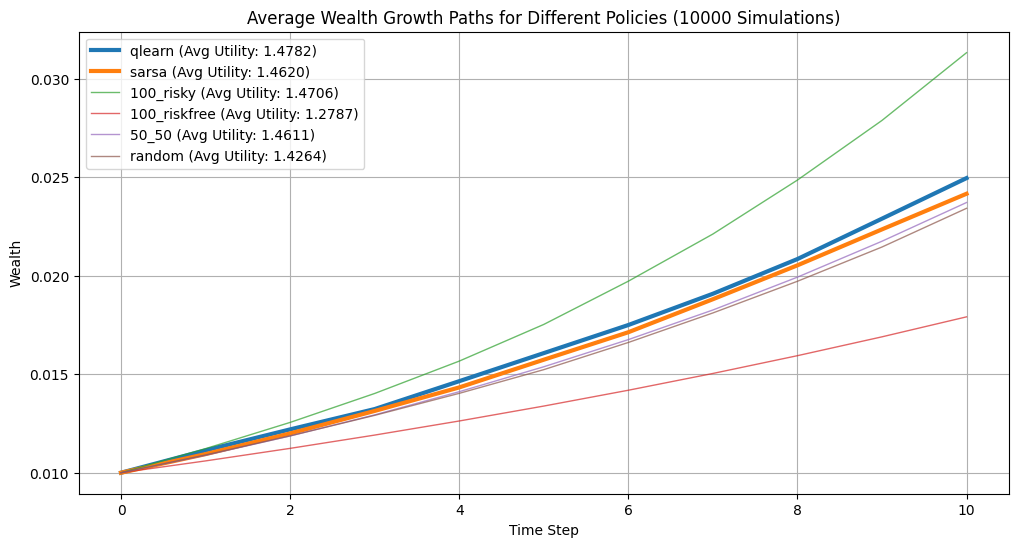

In [28]:
# Helper function for utility computation (aligned with your environment's reward)
def compute_utility(wealth, risk_aversion):
    '''
    Computes the utility for a given wealth and risk aversion.

    Args:
        wealth (float): The current wealth.
        risk_aversion (float): The risk aversion.

    Returns:
    '''
    return (1 - np.exp(-risk_aversion * wealth)) / risk_aversion * 100

# Function to simulate wealth growth path for a given policy
def simulate_policy(env, agent, policy_type, num_simulations=10000, initial_wealth=1):
    '''
    Simulates the wealth growth path for a given policy.

    Args:
        env (PortfolioEnvironment): The environment to simulate the policy on.
        agent (SARSA): The agent to simulate the policy on.
        policy_type (str): The type of policy to simulate.
        num_simulations (int): The number of simulations to run.
        initial_wealth (float): The initial wealth.

    Returns:
        tuple: A tuple containing the wealth paths and utility values.
    '''
    wealth_paths = np.zeros((num_simulations, env.max_steps + 1))  # +1 to include initial wealth
    utility_values = np.zeros(num_simulations)
    
    for sim in range(num_simulations):
        wealth = initial_wealth
        wealth_paths[sim, 0] = wealth
        random_values = np.random.random(env.max_steps)  # Pre-generate random values for consistency
        
        for t in range(env.max_steps):
            steps_remaining = env.max_steps - t
            state = np.array([wealth, steps_remaining])
            
            if policy_type == 'sarsa':
                alloc = agent.get_best_action(state)  # Use trained SARSA agent's best action
            elif policy_type == '100_risky':
                alloc = 1.0
            elif policy_type == '100_riskfree':
                alloc = 0.0
            elif policy_type == '50_50':
                alloc = 0.5
            elif policy_type == 'random':
                alloc = np.random.uniform(0, 1)
            else:
                raise ValueError(f"Unknown policy type: {policy_type}")
            
            # Simulate the risky asset return using the pre-generated random value
            risky_return = env.risky_asset.up_return if random_values[t] < env.risky_asset.p else env.risky_asset.down_return
            portfolio_return = alloc * risky_return + (1 - alloc) * env.risk_free_return
            wealth *= portfolio_return
            wealth_paths[sim, t + 1] = wealth
        
        utility_values[sim] = compute_utility(wealth, env.risk_aversion)
    
    return wealth_paths, utility_values
# Example usage after training
policies = ['qlearn','sarsa', '100_risky', '100_riskfree', '50_50', 'random']
wealth_paths_dict = {}
utility_dict = {}

for policy in policies:
    if policy !='qlearn':
        wealth_paths, utility_values = simulate_policy(env_xtmid, agent_xtmid, policy)
        wealth_paths_dict[policy] = wealth_paths
        utility_dict[policy] = utility_values
wealth_paths_dict['qlearn'] = qlearn
# Plotting (as in your original snippet)
plt.figure(figsize=(12, 6))
for policy in policies:
    if policy !='qlearn':
        avg_wealth_path = np.mean(wealth_paths_dict[policy], axis=0)/100
        transparency = 0.7 if policy in ['100_risky', '100_riskfree', '50_50', 'random'] else 1
        linewidth = 1 if policy in ['100_risky', '100_riskfree', '50_50', 'random'] else 3
        plt.plot(range(env_xtmid.max_steps + 1), avg_wealth_path, label=f'{policy} (Avg Utility: {np.mean(utility_dict[policy])/100:.4f})', 
                linewidth=linewidth, alpha=transparency)
    else:
        avg_wealth_path = np.mean(wealth_paths_dict[policy], axis=0)/100
        transparency = 0.7 if policy in ['100_risky', '100_riskfree', '50_50', 'random'] else 1
        linewidth = 1 if policy in ['100_risky', '100_riskfree', '50_50', 'random'] else 3
        plt.plot(range(env_xtmid.max_steps + 1), avg_wealth_path, label=f'{policy} (Avg Utility: {1.4782})', 
                linewidth=linewidth, alpha=transparency)

plt.xlabel('Time Step')
plt.ylabel('Wealth')
plt.title('Average Wealth Growth Paths for Different Policies (10000 Simulations)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Print statistics
import pandas as pd
summary_df = {}
for policy in policies:
    final_wealth = wealth_paths_dict[policy][:, -1]
    avg_wealth = np.mean(final_wealth)
    std_wealth = np.std(final_wealth)
    avg_utility = np.mean(utility_dict[policy])
    summary_df[policy] = [avg_wealth, std_wealth, avg_utility]
summary_df = pd.DataFrame(summary_df, index=['avg_wealth', 'std_wealth', 'avg_utility'])
summary_df.round(4)

,sarsa,100_risky,100_riskfree,50_50,random
avg_wealth,2.4319,3.0901,1.7908,2.3692,2.3826
std_wealth,1.0496,2.7581,0.0000,0.9853,1.1463
avg_utility,146.9480,145.9070,127.8656,146.0542,144.3662
